### Sayama 12.6

Using the formula for binomial distribution, we can integrate over the given function and find that the probabilities sum up to 1. Analytically, we can also say that, since each scenario is presented with the formula of the binomial distribution: and, since when this formula is integrated, it sums up to 1, then if our scenarios present all the possibilities (from 0 to 4 and from 5 to 8 for the first one; from 0 to 3 and from 4 to 8 for the second one), weighted (p or 1-p, adding up to 100% as well), they will add up to 1 once integrated.

My notebook is giving the error due to the fact that factorial function only works with integers (and I have not figured out yet which function would be the best alternative), but otherwise the function must work.

In [1]:
import math
import scipy
import scipy.integrate as integrate

def new_p(p):
    scen1 = (1 - p)*integrate.quad(lambda k: (math.factorial(8)/(math.factorial(k)*math.factorial(8 - k)))*(p**k)*((1 - p)**(8 - k)), 0, 4)
    scen2 = (1 - p)*integrate.quad(lambda k: (math.factorial(8)/(math.factorial(k)*math.factorial(8 - k)))*(p**k)*((1 - p)**(8 - k)), 5, 8)
    scen3 = p*integrate.quad(lambda k: (math.factorial(8)/(math.factorial(k)*math.factorial(8 - k)))*(p**k)*((1 - p)**(8 - k)), 0, 3)
    scen4 = p*integrate.quad(lambda k: (math.factorial(8)/(math.factorial(k)*math.factorial(8 - k)))*(p**k)*((1 - p)**(8 - k)), 4, 8)
    return scen1 + scen2 + scen3 + scen4

new_p(0.4)

ValueError: factorial() only accepts integral values

### Sayama 12.7

In [2]:
import sympy
# Use p as a symbolic variable
from sympy.abc import p
# The binomial coefficient function (n choose k)
from scipy.special import comb

# (1 - p) is for the scenario of a dead cell - it comes alive when there is strictly 3 cells alive in the neighborhood
# p is for the scenario of the cell that is alive - it stays alive when there are strictly 2 or 3 cells alive around
result = (1-p) * comb(8, 3) * p**3 * (1-p)**(8-3) + p * sum([comb(8, k) * p**k * (1-p)**(8-k) for k in range(2, 4)])

print(sympy.simplify(result))

p**3*(p - 1)**5*(28.0*p - 84.0)


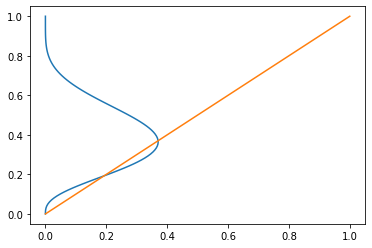

In [3]:
from matplotlib import pyplot as plt
import numpy as np

def f(x):
    return x**3*(x - 1)**5*(28.0*x - 84.0)

x = np.linspace(0, 1, 100)

def y(x):
    return x

plt.plot(f(x), x)
plt.plot(y(x), x)
plt.show()

As can be observed, the 0.2 is a fixed point - if we pick any initial value between 0 and 0.4, and bounce between the function and straight line of y = x, it will eventually settle near 0.2. Else, the cobweb will diverge.

Now I test the result with my Game of Life code from the previous session.

In [4]:
## "pycxsimulator.py"
## Realtime Simulation GUI for PyCX
##
## Developed by:
## Chun Wong
## email@chunwong.net
##
## Revised by:
## Hiroki Sayama
## sayama@binghamton.edu
##
## Copyright 2012 Chun Wong & Hiroki Sayama
##
## Simulation control & GUI extensions
## Copyright 2013 Przemyslaw Szufel & Bogumil Kaminski
## {pszufe, bkamins}@sgh.waw.pl
##
## Fixing errors due to "the grid and pack problem" by:
## Toshihiro Tanizawa
## tanizawa@ee.kochi-ct.ac.jp
## began at 2016-06-15(Wed) 17:10:17
## fixed grid() and pack() problem on 2016-06-21(Tue) 18:29:40
##
## The following two lines should be placed at the beginning of your simulator code:
##
## import matplotlib
## matplotlib.use('TkAgg')

import pylab as PL
from tkinter import ttk
from tkinter import *
from tkinter.ttk import Notebook


class GUI:

    ## GUI variables
    titleText = 'PyCX Simulator'  # window title
    timeInterval = 0              # refresh time in milliseconds
    running = False
    modelFigure = None
    stepSize = 1
    currentStep = 0
    
    # Constructor
    def __init__(self, title='PyCX Simulator', interval=0, stepSize=1, parameterSetters=[]):
        self.titleText = title
        self.timeInterval = interval
        self.stepSize = stepSize
        self.parameterSetters = parameterSetters
        self.varEntries = {}
        self.statusStr = ""
               
        self.initGUI()
        
        
    # Initialization
    def initGUI(self):
        
        #create root window
        self.rootWindow = Tk()
        self.statusText = StringVar(value=self.statusStr) # at this point, statusStr = ""
        self.setStatusStr("Simulation not yet started")

        self.rootWindow.wm_title(self.titleText) # titleText = 'PyCX Simulator'
        self.rootWindow.protocol('WM_DELETE_WINDOW', self.quitGUI)
        self.rootWindow.geometry('450x300')
        self.rootWindow.columnconfigure(0, weight=1)
        self.rootWindow.rowconfigure(0, weight=1)
        
        self.notebook = Notebook(self.rootWindow)      
        # self.notebook.grid(row=0,column=0,padx=2,pady=2,sticky='nswe') # commented out by toshi on 2016-06-21(Tue) 18:30:25
        self.notebook.pack(side=TOP, padx=2, pady=2)
        
        self.frameRun = Frame()
        self.frameSettings = Frame()
        self.frameParameters = Frame()
        self.frameInformation = Frame()          
        
        self.notebook.add(self.frameRun,text="Run")
        self.notebook.add(self.frameSettings,text="Settings")
        self.notebook.add(self.frameParameters,text="Parameters")
        self.notebook.add(self.frameInformation,text="Info")
        self.notebook.pack(expand=NO, fill=BOTH, padx=5, pady=5 ,side=TOP)
        # self.notebook.grid(row=0, column=0, padx=5, pady=5, sticky='nswe')   # commented out by toshi on 2016-06-21(Tue) 18:31:02
        
        self.status = Label(self.rootWindow, width=40,height=3, relief=SUNKEN, bd=1, textvariable=self.statusText)
        # self.status.grid(row=1,column=0,padx=5,pady=5,sticky='nswe') # commented out by toshi on 2016-06-21(Tue) 18:31:17
        self.status.pack(side=TOP, fill=X, padx=5, pady=5, expand=NO)

        # -----------------------------------
        # frameRun
        # -----------------------------------
        # buttonRun
        self.runPauseString = StringVar()
        self.runPauseString.set("Run")
        self.buttonRun = Button(self.frameRun,width=30,height=2,textvariable=self.runPauseString,command=self.runEvent)
        self.buttonRun.pack(side=TOP, padx=5, pady=5)
        self.showHelp(self.buttonRun,"Runs the simulation (or pauses the running simulation)")
        
        # buttonStep
        self.buttonStep = Button(self.frameRun,width=30,height=2,text='Step Once',command=self.stepOnce)
        self.buttonStep.pack(side=TOP, padx=5, pady=5)
        self.showHelp(self.buttonStep,"Steps the simulation only once")
        
        # buttonReset
        self.buttonReset = Button(self.frameRun,width=30,height=2,text='Reset',command=self.resetModel)
        self.buttonReset.pack(side=TOP, padx=5, pady=5) 
        self.showHelp(self.buttonReset,"Resets the simulation")

        # -----------------------------------
        # frameSettings
        # -----------------------------------
        can = Canvas(self.frameSettings)
        
        lab = Label(can, width=25,height=1,text="Step size ", justify=LEFT, anchor=W,takefocus=0)
        lab.pack(side='left')
        
        self.stepScale = Scale(can,from_=1, to=50, resolution=1,command=self.changeStepSize,orient=HORIZONTAL, width=25,length=150)
        self.stepScale.set(self.stepSize)
        self.showHelp(self.stepScale,"Skips model redraw during every [n] simulation steps\nResults in a faster model run.")
        self.stepScale.pack(side='left')
        
        can.pack(side='top')
    
        can = Canvas(self.frameSettings)
        lab = Label(can, width=25,height=1,text="Step visualization delay in ms ", justify=LEFT, anchor=W,takefocus=0)
        lab.pack(side='left')
        self.stepDelay = Scale(can,from_=0, to=max(2000,self.timeInterval),
                               resolution=10,command=self.changeStepDelay,orient=HORIZONTAL, width=25,length=150)
        self.stepDelay.set(self.timeInterval)
        self.showHelp(self.stepDelay,"The visualization of each step is delays by the given number of milliseconds.")
        self.stepDelay.pack(side='left')
        
        can.pack(side='top')
        
        # --------------------------------------------
        # frameInformation
        # --------------------------------------------
        scrollInfo = Scrollbar(self.frameInformation)
        self.textInformation = Text(self.frameInformation, width=45,height=13,bg='lightgray',wrap=WORD,font=("Courier",10))
        scrollInfo.pack(side=RIGHT, fill=Y)
        self.textInformation.pack(side=LEFT,fill=BOTH,expand=YES)
        scrollInfo.config(command=self.textInformation.yview)
        self.textInformation.config(yscrollcommand=scrollInfo.set)
        
        # --------------------------------------------
        # ParameterSetters
        # --------------------------------------------
        for variableSetter in self.parameterSetters:
            can = Canvas(self.frameParameters)
            
            lab = Label(can, width=25,height=1,text=variableSetter.__name__+" ",anchor=W,takefocus=0)
            lab.pack(side='left')
            
            ent = Entry(can, width=11)
            ent.insert(0, str(variableSetter()))
            
            if variableSetter.__doc__ != None and len(variableSetter.__doc__) > 0:
                self.showHelp(ent,variableSetter.__doc__.strip())
                
            ent.pack(side='left')
                
            can.pack(side='top')
            
            self.varEntries[variableSetter]=ent
            
        if len(self.parameterSetters) > 0:
            self.buttonSaveParameters = Button(self.frameParameters,width=50,height=1,
                                               command=self.saveParametersCmd,text="Save parameters to the running model",state=DISABLED)
            self.showHelp(self.buttonSaveParameters,
                          "Saves the parameter values.\nNot all values may take effect on a running model\nA model reset might be required.")
            self.buttonSaveParameters.pack(side='top',padx=5,pady=5)
            self.buttonSaveParametersAndReset = Button(self.frameParameters,width=50,height=1,
                                                       command=self.saveParametersAndResetCmd,text="Save parameters to the model and reset the model")
            self.showHelp(self.buttonSaveParametersAndReset,"Saves the given parameter values and resets the model")
            self.buttonSaveParametersAndReset.pack(side='top',padx=5,pady=5)
    # <<<<< Init >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    
    def setStatusStr(self,newStatus):
        self.statusStr = newStatus
        self.statusText.set(self.statusStr)
        
        
    # model control functions for changing parameters
    def changeStepSize(self,val):        
        self.stepSize = int(val)
        
    def changeStepDelay(self,val):        
        self.timeInterval= int(val)
        
    def saveParametersCmd(self):
        for variableSetter in self.parameterSetters:
            variableSetter(float(self.varEntries[variableSetter].get()))
            self.setStatusStr("New parameter values have been set")
            
    def saveParametersAndResetCmd(self):
        self.saveParametersCmd()
        self.resetModel()

        
    # <<<< runEvent >>>>>
    # This event is envoked when "Run" button is clicked.
    def runEvent(self):
        self.running = not self.running
        if self.running:
            self.rootWindow.after(self.timeInterval,self.stepModel)
            self.runPauseString.set("Pause")
            self.buttonStep.configure(state=DISABLED)
            self.buttonReset.configure(state=DISABLED)
            if len(self.parameterSetters) > 0:
                self.buttonSaveParameters.configure(state=NORMAL)
                self.buttonSaveParametersAndReset.configure(state=DISABLED)     
        else:
            self.runPauseString.set("Continue Run")
            self.buttonStep.configure(state=NORMAL)
            self.buttonReset.configure(state=NORMAL)
            if len(self.parameterSetters) > 0:
                self.buttonSaveParameters.configure(state=NORMAL)
                self.buttonSaveParametersAndReset.configure(state=NORMAL)

    def stepModel(self):
        if self.running:
            self.modelStepFunc()
            self.currentStep += 1
            self.setStatusStr("Step "+str(self.currentStep))
            self.status.configure(foreground='black')
            if (self.currentStep) % self.stepSize == 0:
                self.drawModel()
            self.rootWindow.after(int(self.timeInterval*1.0/self.stepSize),self.stepModel)

    def stepOnce(self):
        self.running = False
        self.runPauseString.set("Continue Run")
        self.modelStepFunc()
        self.currentStep += 1
        self.setStatusStr("Step "+str(self.currentStep))
        self.drawModel()
        if len(self.parameterSetters) > 0:
            self.buttonSaveParameters.configure(state=NORMAL)

    def resetModel(self):
        self.running = False        
        self.runPauseString.set("Run")
        self.modelInitFunc()
        self.currentStep = 0;
        self.setStatusStr("Model has been reset")
        self.drawModel()

    def drawModel(self):
        PL.ion() # bug fix by Alex Hill in 2013
        if self.modelFigure == None or self.modelFigure.canvas.manager.window == None:
            self.modelFigure = PL.figure()
        self.modelDrawFunc()
        self.modelFigure.canvas.manager.window.update()
        PL.show() # bug fix by Hiroki Sayama in 2016

    def start(self,func=[]):
        if len(func)==3:
            self.modelInitFunc = func[0]
            self.modelDrawFunc = func[1]
            self.modelStepFunc = func[2]            
            if (self.modelStepFunc.__doc__ != None and len(self.modelStepFunc.__doc__)>0):
                self.showHelp(self.buttonStep,self.modelStepFunc.__doc__.strip())                
            if (self.modelInitFunc.__doc__ != None and len(self.modelInitFunc.__doc__)>0):
                self.textInformation.config(state=NORMAL)
                self.textInformation.delete(1.0, END)
                self.textInformation.insert(END, self.modelInitFunc.__doc__.strip())
                self.textInformation.config(state=DISABLED)
                
            self.modelInitFunc()
            self.drawModel()     
        self.rootWindow.mainloop()

    def quitGUI(self):
        PL.close('all')
        self.rootWindow.quit()
        self.rootWindow.destroy()
    
    def showHelp(self, widget,text):
        def setText(self):
            self.statusText.set(text)
            self.status.configure(foreground='blue')
            
        def showHelpLeave(self):
            self.statusText.set(self.statusStr)
            self.status.configure(foreground='black')
        widget.bind("<Enter>", lambda e : setText(self))
        widget.bind("<Leave>", lambda e : showHelpLeave(self))

p is 0.1


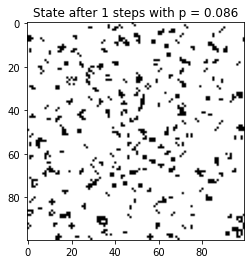

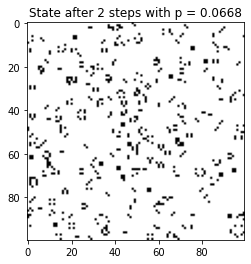

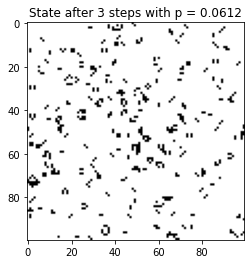

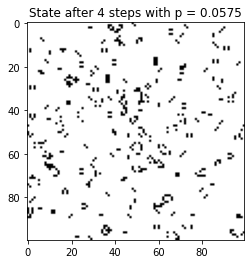

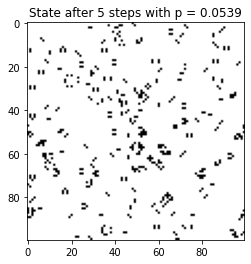

p is 0.2


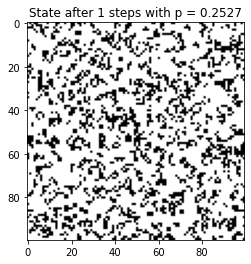

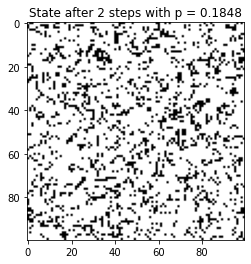

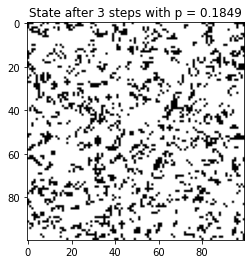

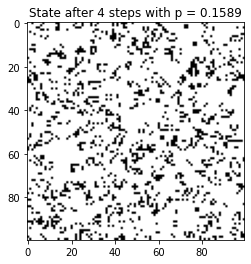

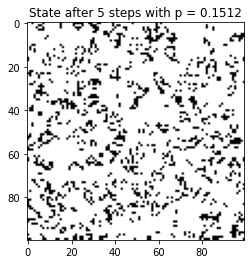

p is 0.30000000000000004


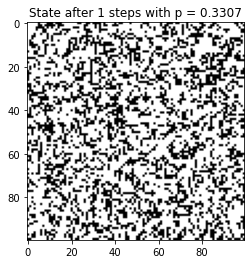

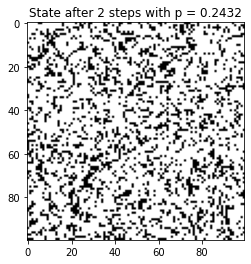

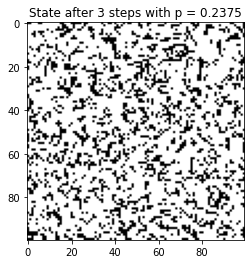

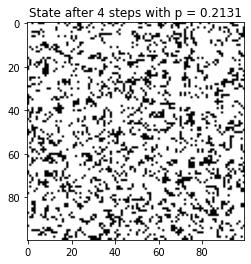

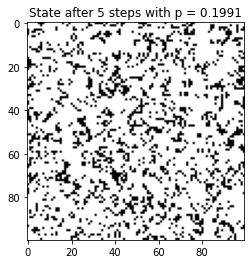

p is 0.4


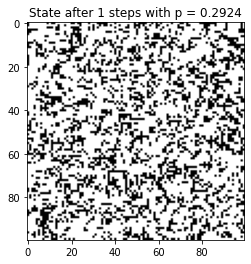

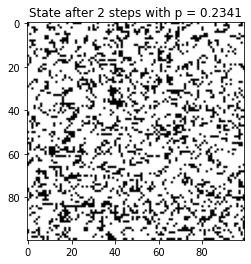

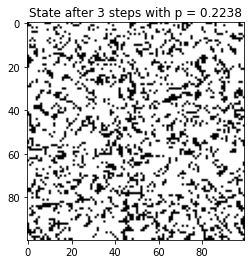

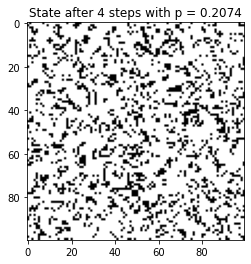

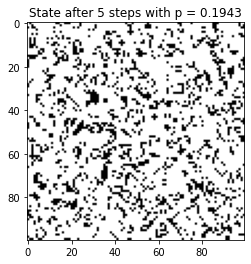

In [5]:
# Game of Life
# Kept having trouble with subplots, so did the other way around :<

import matplotlib
from pylab import *

%matplotlib inline

n = 100 # size of space: n x n
p = 0 # probability of initially panicky individuals

def initialize():
    global config, nextconfig, current_step, current_density
    config = zeros([n, n])
    for x in range(n):
        for y in range(n):
            config[x, y] = 1 if random() < p else 0
    nextconfig = zeros([n, n])
    current_step = 1
    current_density = 0
    
def observe():
    global config, nextconfig, current_step, current_density
    cla()
    plt.imshow(config, vmin = 0, vmax = 1, cmap = cm.binary)
    plt.title(f'State after {current_step} steps with p = {current_density/10**4}')
    plt.show()
    current_step += 1

def update():
    global config, nextconfig, current_step, current_density
    current_density = 0
    for x in range(n):
        for y in range(n):
            count = 0
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    count += config[(x + dx) % n, (y + dy) % n]
                    
            # A dead (quiescent) cell will turn into a living (active) cell if and only if it is surrounded
            # by exactly three living cells.
            
            # A living cell will remain alive if and only if it is surrounded by two or three other living
            # cells. Otherwise it will die.
            
            if config[x, y] == 0: # If the cell was dead
                nextconfig[x, y] = 1 if count == 3 else 0
            else: #If the cell was alive
                nextconfig[x, y] = 1 if count == 2 or count == 3 else 0
                
            current_density = current_density + 1 if nextconfig[x, y] == 1 else current_density
            
    config, nextconfig = nextconfig, config

initialize()
for j in range(4):
    p += 0.1
    initialize()
    print(f'p is {p}')
    for i in range(5):
        update()
        observe()

Although the results are not exactly 0.2, they do tend to stay around 0.2 for some time initially.